In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import pretty_midi
import os

%matplotlib inline
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Some functions

In [2]:
def mu_law_encode(input, channels=256):
    n_q = channels - 1
    mu = torch.tensor(n_q, dtype=torch.float, device=device)
    audio = torch.tensor(input, dtype=torch.float, device=device)
    # audio = torch.abs(torch.tensor(input))
    # audio_abs = torch.min(torch.abs(audio), 1.0)
    mag = torch.log1p(mu * torch.abs(audio)) / torch.log1p(mu)
    signal = torch.sign(audio) * mag
    out = ((signal + 1) / 2 * mu + 0.5)
    out = torch.tensor(out, device=device)
    return out

def mulaw_decode(input, channels=256):
    n_q = channels - 1
    mu = torch.tensor(n_q, dtype=torch.float, device=device).item()
    audio = torch.tensor(input, dtype=torch.float, device=device).item(),
    audio = (audio / mu) * 2 - 1
    out = torch.sign(audio) * (torch.exp(torch.abs(audio) * torch.log1p(mu)) - 1) / mu
    return out

# def one_hot_encode(input, channels=256):
#     size = input.size()[0]
#     one_hot = torch.ShortTensor(size, channels)
#     one_hot = one_hot.zero_()
#     in1 = torch.tensor(input, dtype=torch.long, device='cpu')
#     one_hot.scatter_(1, in1.unsqueeze(1), 1.0)
#     one_hot = one_hot.to(device)
#     return one_hot


# def one_hot_decode(input):
#     _, i = input.max(1)
#     return torch.tensor(i)



### Code for transforming .midi audio to .wav 

In [3]:
# from midi2audio import FluidSynth

# fs = FluidSynth()
# # fs.midi_to_audio('notebooks/test.midi', 'notebooks/test3.wav')
# midi_dir = 'maestro-v1.0.0/2004'
# wav_dir = 'dataset'

# os.makedirs(wav_dir, exist_ok=True)

# # Loop through all MIDI files in the directory
# for midi_file in os.listdir(midi_dir):
#     if midi_file.endswith('.midi'):
#         midi_path = os.path.join(midi_dir, midi_file)
#         wav_path = os.path.join(wav_dir, midi_file.replace('.midi', '.wav'))
        
#         # Convert MIDI to WAV
#         fs.midi_to_audio(midi_path, wav_path)
#         print(f"Converted {midi_path} to {wav_path}")
    


### Code for creating 1sec chunks for training

In [4]:
# import soundfile as sf

# # Parameters
# sample_rate = 16000  # Desired sample rate
# chunk_duration = 1  # Duration of each chunk in seconds
# chunk_length = sample_rate * chunk_duration  # Number of samples per chunk

# # Directories
# input_dir = 'dataset'  # Folder with your 200 audio files
# output_dir = 'data_chunks'  # Folder to save the chunks
# os.makedirs(output_dir, exist_ok=True)

# file_idx = 0
# # Loop through all audio files
# for audio_file in os.listdir(input_dir):
#     if audio_file.endswith('.wav'):
#         # Load the audio file
#         audio_path = os.path.join(input_dir, audio_file)
#         audio, sr = librosa.load(audio_path, sr=sample_rate)

#         # Split into chunks
#         num_chunks = len(audio) // chunk_length
#         for i in range(num_chunks):
#             start_sample = i * chunk_length
#             end_sample = start_sample + chunk_length
#             chunk = audio[start_sample:end_sample]

#             # Save the chunk
#             chunk_filename = f"chunk{file_idx}_{i}.wav"
#             chunk_path = os.path.join(output_dir, chunk_filename)
#             sf.write(chunk_path, chunk, sample_rate)
#             print(f"Saved {chunk_path}")
#         file_idx += 1
#         # Do not save last partial chunk
# print("All audio files have been split into chunks.")


### Code for creating X, y pairs for training

In [5]:
# import librosa

# block_size = 16
# sample_rate = 16000 
# chunk_dir = 'data_chunks' 
# output_dir_X = 'processed_chunks_16/X' 
# output_dir_Y = 'processed_chunks_16/Y'
# os.makedirs(output_dir_X, exist_ok=True)
# os.makedirs(output_dir_Y, exist_ok=True)

# def build_and_save_pairs(audio, block_size,base_filename):
#     context = torch.zeros(block_size, dtype=torch.int16, device=device)
#     idx = 0
#     for i in range(len(audio) - block_size):
#         target = audio[i + block_size]
#         X = torch.tensor(context, dtype=torch.int16, device=device)
#         Y = torch.tensor(target, dtype=torch.int16, device=device)
#         context = torch.cat((context[1:], torch.tensor([target], dtype=torch.int16, device=device)))

#         X_filename = f"{base_filename}_X_{idx}.pt"
#         Y_filename = f"{base_filename}_Y_{idx}.pt"
#         X_path = os.path.join(output_dir_X, X_filename)
#         Y_path = os.path.join(output_dir_Y, Y_filename)

#         torch.save(X, X_path)
#         torch.save(Y, Y_path)
#         print(f"Saved {X_path} and {Y_path}")
#         idx += 1


# for chunk_file in os.listdir(chunk_dir):
#     if chunk_file.endswith('.wav'):
#         chunk_path = os.path.join(chunk_dir, chunk_file)
        
#         audio, sr = librosa.load(chunk_path, sr=sample_rate)

#         audio = mu_law_encode(audio)

#         base_filename = os.path.splitext(chunk_file)[0]
        
#         build_and_save_pairs(audio, block_size, base_filename)

# print("Finished processing all chunks.")



In [6]:
# # check some X,y pairs
# for i in range(100):
#     X = torch.load(f'processed_chunks/X/chunk87_272_X_{i}.pt')
#     y = torch.load(f'processed_chunks/Y/chunk87_272_Y_{i}.pt')
#     print(f"{X.tolist()} -> {y.item()}")

In [3]:


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), device=device) / (fan_in**0.5) 
        self.bias = torch.zeros(fan_out, device=device) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim, device=device)
        self.beta = torch.zeros(dim, device=device)

        self.running_mean = torch.zeros(dim, device=device)
        self.running_var = torch.ones(dim, device=device)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)

            xmean = x.mean(dim=dim, keepdim=True)
            xvar = x.var(dim=dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class LeakyRelu:
    def __call__(self, x):
        self.out = torch.nn.functional.leaky_relu(x)
        return self.out
    
    def parameters(self):
        return []
    
class Relu:
    def __call__(self, x):
        self.out = torch.nn.functional.relu(x)
        return self.out
    
    def parameters(self):
        return []
    

class Adam:
    def __init__(self, params, lr=0.001, beta1 = 0.9, beta2 = 0.999, eps = 1e-08):
        self.lr = lr
        self.params = params
        self.beta1 = torch.tensor(beta1, device=device)
        self.beta2 = torch.tensor(beta2, device=device)
        self.eps = eps
        self.m_d = {id(p) : torch.zeros_like(p) for p in params}
        self.v_d = {id(p) : torch.zeros_like(p) for p in params}
        self.t = 1

    def step(self):
        for param in self.params:
            grad = param.grad
            m = self.m_d[id(param)]
            v = self.v_d[id(param)]

            next_m = (torch.multiply(self.beta1, m) + torch.multiply(1.0 - self.beta1, grad))
            next_v = (torch.multiply(self.beta2, v) + torch.multiply(1.0 - self.beta2, torch.pow(grad, 2)))

            m_hat = torch.divide(next_m, (1 - torch.pow(self.beta1, self.t)))
            v_hat = torch.divide(next_v, (1 - torch.pow(self.beta2, self.t)))

            param.data = param.data - torch.divide(torch.multiply(self.lr, m_hat), (torch.sqrt(v_hat) + self.eps))

            self.m_d[id(param)] = next_m
            self.v_d[id(param)] = next_v
        self.t += 1
    

class Flatten:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

n_embd = 24
n_hidden = 128
vocab_size = 256

model = Sequential([
    Flatten(2), Linear(vocab_size * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), LeakyRelu(),
    Flatten(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), LeakyRelu(),
    Flatten(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), LeakyRelu(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

# parameters = model.parameters()
# print(sum(p.nelement() for p in parameters))
# for p in parameters:
#     p.requires_grad = True
for p in model.parameters():
    p.requires_grad = True



In [58]:
from torch.utils.data import Dataset, DataLoader
import soundfile as sf 

class AudioDataset(Dataset):
    def __init__(self, X_dir, Y_dir):
        self.X_dir = X_dir
        self.Y_dir = Y_dir
        self.X_files = sorted(os.listdir(X_dir))
        self.Y_files = sorted(os.listdir(Y_dir))
        
        # Check if X and Y files match in length
        assert len(self.X_files) == len(self.Y_files), "Mismatch between X and Y files"
    
    def __len__(self):
        # Total number of samples in the dataset
        return len(self.X_files)
    
    def __getitem__(self, idx):
        # Load the X and Y tensors for the given index
        X_path = os.path.join(self.X_dir, self.X_files[idx])
        Y_path = os.path.join(self.Y_dir, self.Y_files[idx])
        
        # Load tensors from files
        X = torch.load(X_path)  # Convert to long if needed for compatibility with model
        Y = torch.load(Y_path)  # Convert to long if needed

        X = torch.tensor(X, dtype=torch.long)
        Y = torch.tensor(Y, dtype=torch.long)

        X_one_hot = torch.nn.functional.one_hot(X, 256).float()
        Y_one_hot = torch.nn.functional.one_hot(Y, 256).float()
        
        return X_one_hot, Y_one_hot


In [65]:
X_dir = 'processed_chunks/X'
Y_dir = 'processed_chunks/Y'
ud, lossi = [], []


lr = 0.001
batch_size = 64
num_steps = 2000

optimizer = Adam(model.parameters(), lr=lr)
audio_dataset = AudioDataset(X_dir, Y_dir)
train_loader = DataLoader(audio_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

for step, (X_batch, Y_batch) in enumerate(train_loader):
    if step >= num_steps:
        break
    # Move batches to the desired device, e.g., GPU if available
    X_batch = X_batch.to(device)
    # Y_batch = Y_batch.type(torch.LongTensor)
    Y_batch = Y_batch.to(device)
    logits = model(X_batch)
    loss = F.cross_entropy(logits, Y_batch)
    for p in model.parameters():
        p.grad = None
    loss.backward()
    optimizer.step()

    if step % 100 == 0:
        print(f"{step:7d}/{num_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in model.parameters()])



    

/tmp/ipykernel_14344/1209181039.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X = torch.load(X_path)  # Convert to long if needed for compatibility with model
/tmp/ip

      0/   2000: 3.0184
    100/   2000: 2.6717
    200/   2000: 2.5726
    300/   2000: 3.0226
    400/   2000: 2.6343
    500/   2000: 2.6099
    600/   2000: 2.6454
    700/   2000: 2.9157
    800/   2000: 2.7437
    900/   2000: 2.8038
   1000/   2000: 2.8727
   1100/   2000: 2.9092
   1200/   2000: 2.7925
   1300/   2000: 2.6736
   1400/   2000: 3.0584
   1500/   2000: 3.0396
   1600/   2000: 2.8400
   1700/   2000: 2.6905
   1800/   2000: 2.9492
   1900/   2000: 2.7356


In [67]:
X_batch.shape, Y_batch.shape, model.layers[1].weight.shape, logits.shape, logits

(torch.Size([64, 8, 256]),
 torch.Size([64, 256]),
 torch.Size([512, 128]),
 torch.Size([64, 256]),
 tensor([[-12.5887, -12.7399, -12.7252,  ..., -12.6211, -12.5361, -12.7282],
         [ -8.6361,  -8.7069,  -8.6877,  ...,  -8.7250,  -8.6573,  -8.6853],
         [-25.8020, -25.7372, -25.6968,  ..., -25.6401, -25.5022, -25.7414],
         ...,
         [-28.9569, -28.8350, -28.8749,  ..., -28.7652, -28.6196, -28.8919],
         [-15.4121, -15.5005, -15.5350,  ..., -15.3712, -15.2561, -15.4565],
         [-30.4417, -30.3904, -30.3343,  ..., -30.1223, -30.1536, -30.4121]],
        device='cuda:0', grad_fn=<AddBackward0>))

In [62]:
X_batch.dtype, Y_batch.dtype, model.layers[1].weight.dtype, logits.dtype

(torch.float32, torch.int64, torch.float32, torch.float32)

In [ ]:
print(model.layers[0].weight.shape)


In [ ]:
for x, y in zip(X_batch, Y_batch):
    print(f"X: {x.tolist()} -> Y: {y.item()}")  

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt      
import numpy as np
import torch    
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim import Adam
import librosa

import librosa.display
#from datasets import WaveNetDataset

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1683).mean(1))

In [69]:
for layer in model.layers:
    layer.training = False

In [70]:
num_samples_to_generate = 16000
context = [0] * 8

generated_samples = []

for i in range(num_samples_to_generate):
    # Forward pass: Get predictions for the current context
    context_tensor = torch.nn.functional.one_hot(torch.tensor(context), 256).float().to(device)
    logits = model(context_tensor.unsqueeze(0))  # Forward pass
    probs = F.softmax(logits, dim=1)                          # Softmax for probabilities

    # Sample from the probability distribution
    ix = torch.multinomial(probs, num_samples=1).item()        # Sample next audio sample
    generated_samples.append(ix)                               # Store generated sample

    # Update the context window by shifting and adding the new sample
    context = context[1:] + [ix] 
    if i % 10 == 0:
        print(f"{i:7d}/{num_samples_to_generate:7d}")
    


      0/  16000
     10/  16000
     20/  16000
     30/  16000
     40/  16000
     50/  16000
     60/  16000
     70/  16000
     80/  16000
     90/  16000
    100/  16000
    110/  16000
    120/  16000
    130/  16000
    140/  16000
    150/  16000
    160/  16000
    170/  16000
    180/  16000
    190/  16000
    200/  16000
    210/  16000
    220/  16000
    230/  16000
    240/  16000
    250/  16000
    260/  16000
    270/  16000
    280/  16000
    290/  16000
    300/  16000
    310/  16000
    320/  16000
    330/  16000
    340/  16000
    350/  16000
    360/  16000
    370/  16000
    380/  16000
    390/  16000
    400/  16000
    410/  16000
    420/  16000
    430/  16000
    440/  16000
    450/  16000
    460/  16000
    470/  16000
    480/  16000
    490/  16000
    500/  16000
    510/  16000
    520/  16000
    530/  16000
    540/  16000
    550/  16000
    560/  16000
    570/  16000
    580/  16000
    590/  16000
    600/  16000
    610/  16000
    620/

In [74]:
max(generated_samples), min(generated_samples)

(190, 18)

In [75]:
def mulaw_decode(input, channels=256):
    n_q = channels - 1
    mu = torch.tensor(n_q, dtype=torch.float, device=device)
    audio = torch.tensor(input, dtype=torch.float, device=device)
    audio = (audio / mu) * 2 - 1
    out = torch.sign(audio) * (torch.exp(torch.abs(audio) * torch.log1p(mu)) - 1) / mu
    return out

In [76]:
decoded_audio = mulaw_decode(torch.tensor(generated_samples))

/tmp/ipykernel_14344/4033718438.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  audio = torch.tensor(input, dtype=torch.float, device=device)


In [81]:
#print max from decoded audio
print(decoded_audio.max())
print(decoded_audio.min())

tensor(0.0555, device='cuda:0')
tensor(-0.4550, device='cuda:0')


In [ ]:
# from scipy.io.wavfile import write

# write('generated_audio.wav', 16000, decoded_audio.numpy().astype(np.float32))

In [84]:
from IPython.display import Audio

# Play audio in Jupyter Notebook
Audio(decoded_audio.cpu().numpy(), rate=16000)

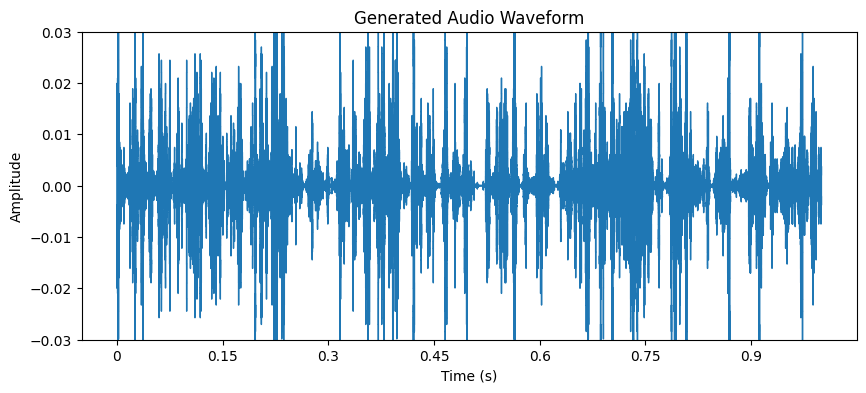

In [82]:
import matplotlib.pyplot as plt
import librosa.display

# Convert decoded_audio to a NumPy array if it’s a tensor
if isinstance(decoded_audio, torch.Tensor):
    decoded_audio_np = decoded_audio.cpu().numpy()  # Ensure it's on CPU and convert to numpy
else:
    decoded_audio_np = decoded_audio  # If it's already a numpy array, keep it as is

# Set up the plot
plt.figure(figsize=(10, 4))
librosa.display.waveshow(decoded_audio_np, sr=16000)  # Assuming a sample rate of 16kHz
plt.title('Generated Audio Waveform')
plt.xlabel('Time (s)')
plt.ylim(-0.03, 0.03)
plt.ylabel('Amplitude')
plt.show()


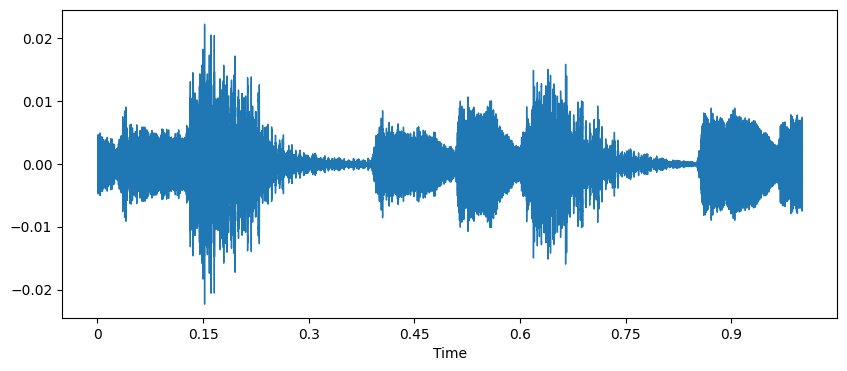

In [83]:
# plot example audio from data_chunks .wav

# Load the audio file
audio_path = 'data_chunks/chunk1_100.wav'
audio, sr = librosa.load(audio_path, sr=16000)

# Set up the plot
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sr)